In [5]:
try:
    import pandas as pd
except ImportError as e:
    %pip install pandas
import numpy as np
try: 
    from huggingface_hub import hf_hub_download
except ImportError as e:
    %pip install huggingface_hub
try:
    import seaborn as sns
except ImportError as e:
    %pip install seaborn
try:
    from matplotlib import pyplot as plt
except ImportError as e:
    %pip install matplotlib

This notebook demonstrates how to use optimization data from the ARLBench Hugging Face to analyze the configurations tested during each optimization run. We will then perform a basic evaluation of this data.

Each optimization run is roughly equivalent to 30 full training runs, with each configuration being evaluated across three different random seeds to ensure robustness.

To begin, we define the necessary values to normalize performance. For ALE environments, we apply a standard normalization approach. For all other environments, we normalize using the minimum and maximum performance values observed in our landscape data.

In [6]:
repo_id = "autorl-org/arlbench"

average_human = {
    "atari_battle_zone": 37187.5,
    "atari_qbert": 13455,
    "atari_phoenix": 7242.6,
    "atari_this_game": 8049,
    "atari_double_dunk": -16.4,
}
random_score = {
    "atari_battle_zone": 2360.0,
    "atari_qbert": 163.9,
    "atari_phoenix": 761.4,
    "atari_this_game": 2292.3,
    "atari_double_dunk": -18.6,
}

def ale_normalize_score(perf, env_name):
    rs = random_score[env_name]
    ah = average_human[env_name]
    return (perf - rs) / (ah - rs)

def env_landscape_min_max(env_name, algorithm):
    hugging_face_landscape_file = f"landscapes/{env_name}_{algorithm}.csv"
    df = pd.read_csv(hf_hub_download(
            repo_id=repo_id, filename=hugging_face_landscape_file, repo_type="dataset"
    ))
    hp_keys = [key for key in df.keys() if "hp_" in key]
    df[hp_keys] = df[hp_keys].fillna("NaN")

    df["config_id"] = df["config_id"].fillna(min(df["performance"]))
    df = df[df["training_steps"] == max(df["training_steps"])]
    
    if "brax" in env_name:  
        df["performance"] = df["performance"].clip(lower=-2000)
    elif "box2d" in env_name:
        df["performance"] = df["performance"].clip(lower=-200)

    return min(df["performance"]), max(df["performance"])

The list below can be modified to adjust which optimization runs are computed.

In [7]:
environment_names = ["atari_phoenix", "atari_battle_zone"]
algorithm_names = ["ppo", "dqn"]
optimization_algorithms = ["rs", "smac", "smac_mf", "pbt"]

The function below retrieves the raw optimization data from Hugging Face and organizes it by training seeds, optimization seeds, and optimization steps:
- Each optimization run was conducted with five different optimization seeds for every algorithm-environment combination.
- During an optimization run, the algorithm may evaluate multiple configurations in parallel. Configurations evaluated at the same step share the same optimization step value.
- Training seeds represent different random seeds used for each RL training run.

In [8]:
def optimization_summary(opt_algorithm, env_name, algorithm, normalize_performance=False):
        hugging_face_optimizer_file = f"{opt_algorithm}/{env_name}_{algorithm}.csv"
        df = pd.read_csv(hf_hub_download(
            repo_id=repo_id, filename=hugging_face_optimizer_file, repo_type="dataset"
        ))

        # Get all hyperparameter names and add NaN values for unset conditional hyperparameters
        hp_keys = [key for key in df.keys() if "hp_" in key]
        df[hp_keys] = df[hp_keys].fillna("NaN")

        # Set performance of crashing configurations to minimal observed performance
        df["config_id"] = df["config_id"].fillna(min(df["performance"]))

        # Clip lower performance due to numerical instabilities for brax and box2d
        if "brax" in env_name:  
            df["performance"] = df["performance"].clip(lower=-2000)
        elif "box2d" in env_name:
            df["performance"] = df["performance"].clip(lower=-200)

        # If required normalize the performance
        if normalize_performance:
            if not "atari" in env_name:
                min_perf, max_perf = env_landscape_min_max(env_name, algorithm)
                df["performance"] = df["performance"].map(lambda x: (x - min_perf) / (max_perf - min_perf))
            else:
                df["performance"] = ale_normalize_score(df["performance"], env_name)
    
        # Compute the mean performance for each hyperparameter configuration across all 3 training seeds
        df = df.groupby(["config_id", "optimization_seed", "optimization_step"], as_index=False).agg({
            "performance": "mean",
        }).reset_index()

        # For PBT and SMAC+HB multiple configurations are evaluated at each optimization step, we choose the maximum
        df = df.groupby(["optimization_step", "optimization_seed"], as_index=False).agg({
            "performance": "max",
        }).reset_index()

        # Compute the maximal observed past performance for each optimisation timestep
        df = df.sort_values(["optimization_seed", "optimization_step"])
        df["performance"] = df.groupby('optimization_seed', as_index=False)["performance"].cummax()
        df["optimization_step"] = df["optimization_step"] / df["optimization_step"].max()

        return df


We now compute the non-normalized landscape for the selected environment and algorithm combinations. Set `normalize_performance` to examine the normalized values.

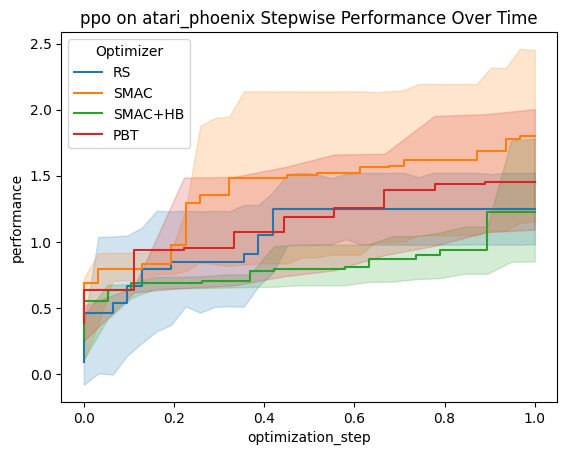

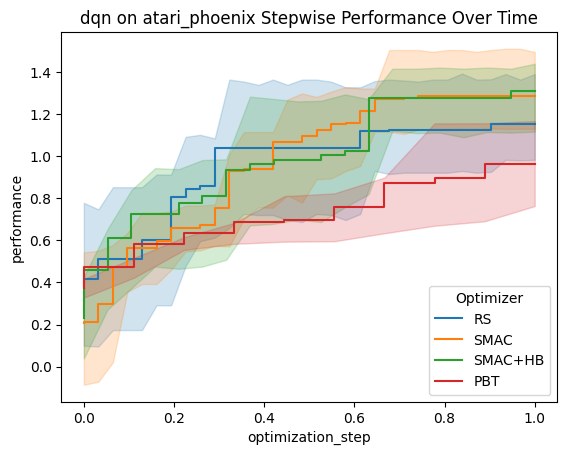

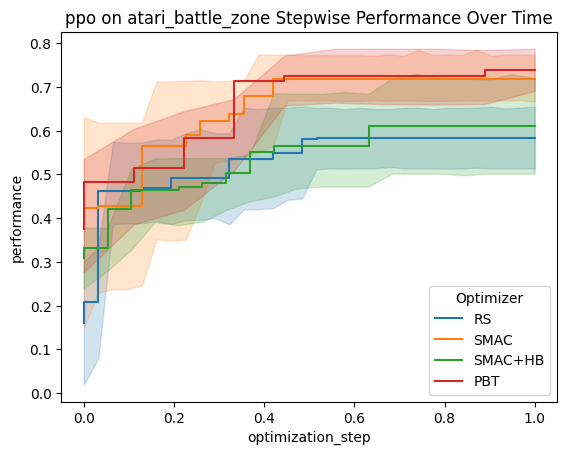

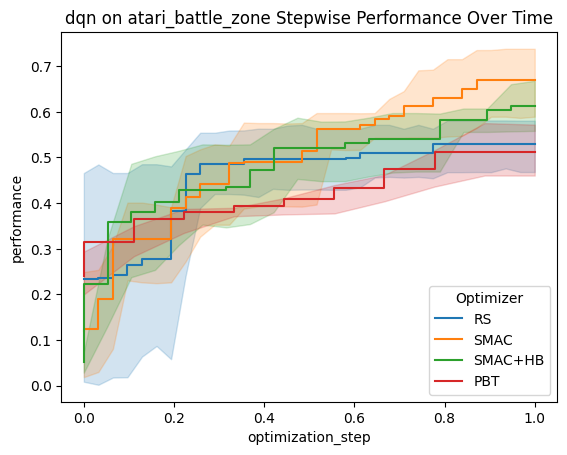

In [9]:

for env in environment_names:
    for algo in algorithm_names:
        fig, ax = plt.subplots()
        dfs = []
        for opt in optimization_algorithms:
            df = optimization_summary(opt, env, algo, normalize_performance=True)
            df["optimizer"] = opt
            dfs.append(df)
        ax.set_title(f"{algo} on {env} Stepwise Performance Over Time")
        sns.lineplot(data=pd.concat(dfs), x='optimization_step', y='performance', hue="optimizer", errorbar=("ci", 95), drawstyle="steps", ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        custom_labels = ["RS", "SMAC", "SMAC+HB", "PBT"]  # Custom labels
        ax.legend(handles, custom_labels, title="Optimizer")
        plt.show()